In [2]:
import numpy as np

## Softmax

Обобщение логистической функции для многомерного случая. Функция преобразует вектор $z$ размерности $K$ в вектор $\sigma$ той же размерности, где каждая координата $\sigma_i$ полученного вектора представлена вещественным числом в интервале $[0,1]$ и сумма координат равна 1.

Координаты $\sigma_i$ вычисляются следующим образом:


${\displaystyle \sigma (z)_{i}={\frac {e^{z_{i}}}{\displaystyle \sum _{k\mathop {=} 1}^{K}e^{z_{k}}}}}$

1. Реализуйте функцию softmax, которая на вход принимает вектор $z$, а на выходе считает от него софтмакс.
2. Добавьте возможность принимать на вход матрицу и считать softmax по столбцам (батч)

In [3]:
# 1
def softmax(z):
    z = np.array(z)
    denominator = np.exp(z).sum()
    smz = np.exp(z) / denominator
    return smz

In [4]:
z = np.array([1,2,3])
softmax(z)

array([ 0.09003057,  0.24472847,  0.66524096])

In [5]:
softmax(z).sum()

1.0

In [6]:
# 2
def softmax_col(z):
    z = np.array(z)
    denominator = np.exp(z).sum(axis = 0)
    smz = (np.exp(z) / denominator)
    return smz

In [7]:
z = np.array([[1,2,3],
              [1,1,1],
              [9,9,9],
              [8,7,6]])
softmax_col(z)

array([[  2.45122603e-04,   8.02301516e-04,   2.35488234e-03],
       [  2.45122603e-04,   2.95150233e-04,   3.18698669e-04],
       [  7.30700181e-01,   8.79830446e-01,   9.50027343e-01],
       [  2.68809574e-01,   1.19072103e-01,   4.72990763e-02]])

In [8]:
softmax_col(z).sum(axis=0)

array([ 1.,  1.,  1.])

## Дивергенция Кульбака-Лейблера

* Показать что $D_{KL}(p||q) \ge 0$ для любых $p$ и $q$. Для этого можно воспользоваться [формулой Йенсена](https://en.wikipedia.org/wiki/Jensen%27s_inequality "неравенство Йенсена")
* ~~Показать, что максимизация правдопобия эквивалентна минимизации $D_{KL}$~~. 

<img src='firstn.jpg'>

## GLM

На слайде 27 в лекциях показывается, что распределение Бернулли входит в экспоненциальное семейство. Чему равно $\phi$?

<img src='secondn.jpg'>

## Обучение линейных моделей

Буквально три-четыре года назад для того, чтобы обучить нейронную сеть было необходимо вручную вычислить градиент функции потерь. Затем, обычно, правильность решения проверялась численно. После появления фреймворков вроде Theano и TF это стало необязательным, благодаря чему исследователи и инженеры могут проводить свои эксперименты значительно быстрее. В данной работе мы посчитаем и проверим градиенты для линейных моделей, рассмотренных на первой лекции; а так же в явном виде реализуем алгоритм оптимизации.      

In [1]:
import numpy as np
from keras.datasets import cifar10
from random import randrange
import time

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

Для обучения мы будем использовать датасет CIFAR-10, состоящий из 60000 цветных изображений размера 32x32, разбитых на 10 классов, по 6000 изображений на класс. Обучающая выборка состоит из 50000 изображений, а тестовая -- из 10000. 

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170450944/170498071 [============================>.] - ETA: 0s   

In [5]:
x_train.shape

(50000, 32, 32, 3)

Визуализируем классы

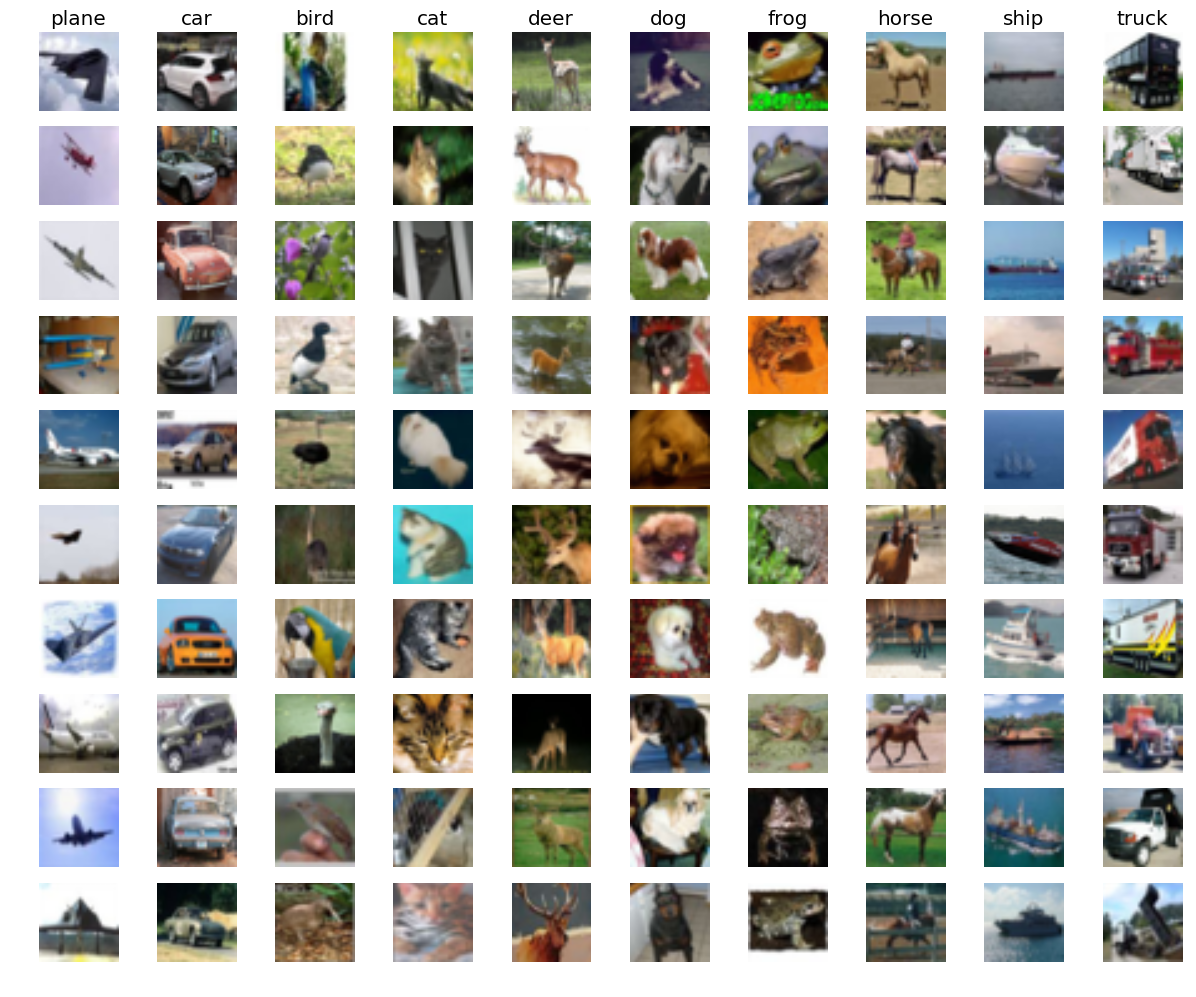

In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [13]:
# Preprocessing: преобразуем изображения к плоскому виду
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))

# Печатаем размерности, чтобы проверить что мы не ошиблись
print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)


[ 130.71074  136.05614  132.5538   130.14036  135.44238  131.85358
  131.05044  136.24616  132.58144  131.56886]


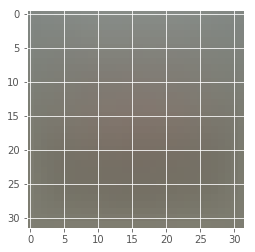

In [14]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
print(mean_image[:10]) # для проверки напечаем несколько элементов
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
plt.show()

In [15]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

In [16]:
print(x_train.shape)

(50000, 3072)


In [17]:
# 3: Добавляем новую компоненту отвечающую за сдвиг (bias trick)
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])

In [18]:
print(x_train.shape)

(50000, 3073)


**Задача 1:** Далее следует функция svm_loss, которую вам предстоит дописать.

In [23]:
def svm_loss(W, X, y, reg):
    """
    SVM loss function
    Inputs:
    - W: Матрица весов
    - X: Данные
    - y: Целевой признак
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    
    # Впишите свой код на место заглушки
    loss = 0
    dW = np.zeros(W.shape)



    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################


    return loss, dW

In [24]:
# Заполняем матрицу весов W случайным образом
W = np.random.randn(10, 3073) * 0.0001 

loss, grad = svm_loss(W, x_test, y_test, 0.000005)
print('loss: %f' % (loss, ))

loss: 0.000000


In [25]:
#При помощи этой функции можно проверить градиент численно 
def grad_check_sparse(f, x, analytic_grad, num_checks):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """
    h = 1e-5

    x.shape
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        x[ix] += h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] -= 2 * h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] += h # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [26]:
# Вычисляем значение функции потерь и её градиент для W.
loss, grad = svm_loss(W, x_test, y_test, 0.0)

# Проверяем численно
f = lambda w: svm_loss(w, x_test, y_test, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Проверяем численно, используя регуляризацию.
# Вы ведь не забыли реализовать регуляризацию, правда? 
loss, grad = svm_loss(W, x_test, y_test, 5e1)
f = lambda w: svm_loss(w, x_test, y_test, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, 

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


**Задача 2:** Реализуйте методы класса SVM. Для тренировки используйте градиентный спуск.

In [29]:
class SVM():
    def __init__(self):
        self.W = np.random.randn(10, 3073) * 0.0001 
        
    def train(self, x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1000, verbose=True):
        #Здесь (на месте заглушки) впишите релаизацию градиентного спуска, используя функцию потерь, которую вы определелили выше.
        #Если обучение проходит слишком медленно, возможно необходимо что-то улучшить?
        loss_history = []
        for it in range(num_iters):
            loss = 0
            loss_history.append(loss)

        return loss_history
    
    def predict(self, y):
        pass

In [ ]:
Проверяем полученную реализацию.

In [ ]:
tic = time.time()
svm = SVM()
loss_hist = svm.train(x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

In [ ]:
# Хорошая идея для отладки -- нарисовать график отношения функци потерь к номеру итерации 
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Теперь вычислим точность на тренировочном и тестовом множествах
y_train_pred = svm.predict(x_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

In [ ]:
def plot_weights(best_svm):
    w = best_svm.W[:,:-1] # strip out the bias
    w = w.reshape(10, 32, 32, 3)
    w_min, w_max = np.min(w), np.max(w)
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    for i in range(10):
        plt.subplot(2, 5, i + 1)

        # Rescale the weights to be between 0 and 255
        wimg = 255.0 * (w[i, :, :, :].squeeze() - w_min) / (w_max - w_min)
        plt.imshow(wimg.astype('uint8'))
        plt.axis('off')
        plt.title(classes[i])

**Задача 3:** Подберите при помощи поиска по сетке наулучшие параметры learning rate и regularization coefficient. Для полученной модели вызовите функцию plot_weights(best_svm). Впишите свой код под этой ячейкой.

**Задача 4:** О чём говорят полученные изображения? Какие выводы мы можем сделать? Впишите ответ в поле ниже

**Задача 5:** Повторим упражнение для cross entropy loss

In [ ]:
def crossentropy_loss(W, X, y, reg):
    """
    Cross entropy loss function
   Inputs:
    - W: Матрица весов
    - X: Данные
    - y: Целевой признак
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    
    # Впишите свой код на место заглушки
    loss = 0
    dW = np.zeros(W.shape)

    return loss, dW

In [ ]:
# Грубая проверка, значения должны быть близки к -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

**Задача 6:** Кстати, почему такая проверка справедлива? Объясните

In [ ]:
# Вычисляем значение функции потерь и её градиент для W.
loss, grad = crossentropy_loss(W, x_test, y_test, 0.0)


f = lambda w: crossentropy_loss(w, x_test, y_test, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


loss, grad = crossentropy_loss(W, x_test, y_test, 5e1)
f = lambda w: crossentropy_loss(w, x_test, y_test, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)